In [1]:
# uncomment here if you need to install the relevant packages
# !pip install torch torchvision torchaudio
# !pip install scikit-learn

# Reinforcement Learning Lab 2: Deep RL
---
In this lab session we will aim to accomplish the following:
- An introduction to [Pytorch](https://pytorch.org);
- Write and implement algorithms for Discrete and Continuous Control (continuous control will be done in a separate notebook);

## First, we will begin by installing Pytorch and looking at it's functionality. 
PyTorch is a popular open-source machine learning library that provides efficient tensor computation and automatic differentiation, making it well-suited for deep reinforcement learning (DRL) tasks. It offers a flexible and intuitive programming model that allows for easy construction of complex neural network architectures commonly used in DRL, such as convolutional and recurrent networks. Additionally, PyTorch supports GPU acceleration, which can greatly speed up training and inference for DRL models (though in this lab we won't need to make use of the GPU's).

We'll briefly go through some quick examples below showing some simple tensor creating/manipulation operations.

In [1]:
import torch

# Create a tensor of zeros with shape (3, 4)
zeros_tensor = torch.zeros((3, 4))

# Create a tensor of ones with shape (4, 2)
ones_tensor = torch.ones((3, 4))

# Create a tensor with random values with shape (2, 3)
rand_tensor = torch.randn((3, 4))

# Add two tensors element-wise
sum_tensor = zeros_tensor + ones_tensor

# Multiply two tensors element-wise
prod_tensor = ones_tensor * rand_tensor

# Reshape a tensor
reshape_tensor = rand_tensor.reshape((4, 3))

print("Zeros tensor:\n", zeros_tensor)
print("Ones tensor:\n", ones_tensor)
print("Random tensor:\n", rand_tensor)
print("Sum of zeros and ones tensors:\n", sum_tensor)
print("Product of ones and random tensors:\n", prod_tensor)
print("Reshaped random tensor:\n", reshape_tensor)

Zeros tensor:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
Ones tensor:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
Random tensor:
 tensor([[-0.0033,  0.8567, -1.1854, -0.4587],
        [-0.3716, -1.6660, -1.3029,  0.2645],
        [ 0.5439, -0.6435,  1.0052,  0.3798]])
Sum of zeros and ones tensors:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
Product of ones and random tensors:
 tensor([[-0.0033,  0.8567, -1.1854, -0.4587],
        [-0.3716, -1.6660, -1.3029,  0.2645],
        [ 0.5439, -0.6435,  1.0052,  0.3798]])
Reshaped random tensor:
 tensor([[-0.0033,  0.8567, -1.1854],
        [-0.4587, -0.3716, -1.6660],
        [-1.3029,  0.2645,  0.5439],
        [-0.6435,  1.0052,  0.3798]])


Above, we have created a tensor of zeros, a tensor of ones, and a randomly generated tensor. The `torch.randn` command creates a tensor with values sampled from a unit-Normal distribution. Another thing to note is how we reshaped the tensor. Whilst it is usually okay to reshape like this, it is important to make sure that the reshaping happens in the way that we expected. Above, we reshaped the tensor to be of shape `(4, 3)`. Now, you might think that this would simply transpose the original tensor of size `(3, 4)`, but we can see that this is actually note the case:

In [21]:
transposed_tensor = rand_tensor.transpose(0, 1)  # transpose the tensor along dimensions 0 and 1. 
print("Transposed tensor:\n", transposed_tensor)

Transposed tensor:
 tensor([[-0.1955, -0.4212,  3.5870],
        [-0.9656, -0.5107, -1.8313],
        [ 0.4224, -1.5727,  1.5987],
        [ 0.2673, -0.1232, -1.2770]])


We can see that the transposed tensor is to the reshaped tensor. In general, when using these commands I would recommend doing a test on a small tensor to make sure that what you were wanting to happen does indeed happen. 

Another thing to note is the data type used in tensors. Usually we will want `Float` data types, e.g. as the input to a Neural Network, but sometimes in RL it is useful to work with the `Long` data type, especially when dealing with discrete actions. Here's an example of creating some tensors with different data types:

In [22]:
# create a tensor of integers
int_tensor = torch.tensor([1, 2, 3, 4], dtype=torch.int32)

# create a tensor of floating-point numbers
float_tensor = torch.tensor([1.0, 2.0, 3.0, 4.0], dtype=torch.float32)

# create a tensor of booleans
bool_tensor = torch.tensor([True, False, True, False], dtype=torch.bool)

PyTorch is also incredibly useful due to its autograd capabilities. Below we'll create a tensor with a gradient and then look to do some calculations, and then use autograd to calculate the gradient:

In [23]:
# Create a tensor with requires_grad=True to track the gradient
x = torch.tensor([3.0], requires_grad=True)

# Compute a function with the tensor
y = x ** 2

# Compute gradients of the function with respect to the tensor
y.backward()

# Print the gradient
print(x.grad)

# Perform calculations with no gradient
x = torch.tensor([3.0], requires_grad=True)
with torch.no_grad():
    y = x ** 2
print(x.grad)

tensor([6.])
None


We've created a tensor with a specific value. Then, we compute the function $f(x) = x^2$ and then use `y.backward()` to calculate the gradient. We know that $f'(x) = 2x$, and so for $x=3$ we would expect the gradient to be 6. This is exactly what autograd gives us! It might seem trivial for this example, but it is useful when the gradient would be difficult to calculate analytically for a more complex function, such as a deep Neural Network. I also added an example of doing the same calculation wrapper in a `torch.no_grad()`, as this will kill any gradient computations -- we will see later that this can be useful. More information on how autograd and the computational graph works can be found [here](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/)

**Above we specified a tensor with a single scalar value. A multi-dimensional tensor can be created by e.g. using** `torch.tensor([3.0, 4.0])` **or** `torch.tensor([[3.0, 4.0], [5.0, 6.0]])`. **What happens if you create a multi-dimensional tensor with a gradient and try and compute the gradient in the same way as the example given?**

---
## Defining and training neural networks in PyTorch. 
Now we will take a look at defining our own network which we can train via gradient descent. We'll go through a simple example where we look to train a classifier on the Iris dataset. I won't do any rigorous treatment of the data or any EDA as the main thing to take away here is defining the network and using the optimiser to minimise the loss function. We'll first begin by loading the data. 

In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the iris dataset
data = load_iris()
X = data.data
y = data.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

Once the data is loaded, we now need to define our network:

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the MLP
input_size = 4
hidden_size = 16
output_size = 3
mlp = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(mlp.parameters(), lr=0.001)

The `MLP` class is network class. Whenever creating a PyTorch network you should always ensure the class is a child class of the `nn.Module`; the main reason being that whenever we assign an optimiser to the network it will know exactly which parameters to optimise, which is any layer we define in the `init` that comes from the `torch.nn` module. Our network only makes use of the `nn.Linear` layer, which is essentially a single linear transformation to the data: $y = xW^T + b$ where $x$ is the input data, $W$ is the learnable set of weights, and $b$ is the (also learnable) bias. Another popular layer that we won't use in this lab is the convolutional layer, `nn.Conv2d`, which applies a convolutional layer.

As for the specific architecture of our network, we see that it has one hidden layer with a `relu` activation in the middle layer. To apply the `relu` activation function, we just use the built in `torch.relu` function to the output of our linear layer -- autograd will handle all the gradient calculations so we don't need to worry about doing anything else! Note that we don't need to apply any activation to our output layer. The reason for this being that the `nn.CrossEntropyLoss` expect a vector of *logit* values, so we don't need to normalise these into probabilities when using this loss function, so keep this in mind as in future we may want our output to have certain values e.g. non-negative or log-probabilities, in which case we will have to apply a relevant transformation such as the `torch.relu` or `torch.log_softmax`!

Once we have defined the network, all that is left to do is define the loss function we wish to use (as mentioned above, this is the `CrossEntropyLoss`, but the `nn` module has other common losses such as `MSELoss`) and also an optimiser. A PyTorch optimiser is a built in gradient descent method. For this example we are using  the [Adam](https://arxiv.org/abs/1412.6980) optimiser which most Deep RL algorithms use. Using an optimiser is very simple -- we simply call the optimiser we want to use and pass as an argument the networks parameters; to find our networks parameters we can use `mlp.parameters()` to return an iterable. Let's see how we do this in practice: 

In [26]:
for epoch in range(10):
    optimiser.zero_grad()  # here we zero any previously accumulated gradients
    y_pred = mlp(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimiser.step()  # here we perform a gradient descent step on our networks parameters, with gradients calculated from the loss
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch + 1}, Loss {loss.item():.4f}')
        
# Evaluate the MLP on the test set
with torch.no_grad():
    y_pred = mlp(X_test)
    _, predicted = torch.max(y_pred.data, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f'Test Accuracy {accuracy:.4f}')

Epoch 1, Loss 1.5900
Epoch 2, Loss 1.5728
Epoch 3, Loss 1.5557
Epoch 4, Loss 1.5389
Epoch 5, Loss 1.5222
Epoch 6, Loss 1.5058
Epoch 7, Loss 1.4894
Epoch 8, Loss 1.4733
Epoch 9, Loss 1.4572
Epoch 10, Loss 1.4413
Test Accuracy 0.7333


And there we have it -- we have trained our first PyTorch neural network! We can now try and train it on something more interesting. 😊

---

# Deep Q-Learning
The success that Deep Q-Learning had on the Atari games, and later in the game of Go, is largely the reason for a huge surge in interest in Deep RL, so it seems a natural place for us to start! To implement Deep Q-Learning we will need the following components
1. A Deep Q-Network -- this is what we will replace the Q-table with from tabular RL; 
2. A replay buffer to store our experiences in -- as Q-Learning is an off-policy algorithm, we can learn from previous experience which greatly increases our sample efficiency;
3. The actual learning algorithm itself.
Before we get to work implementing these ingredients of Deep Q-Learning (which we will also refer to as DQN), let's quickly recap ourselves on the loss used for the DQN algorithm, as this will be useful later when you come to implement it. To train a DQN, we minimise the following squared error: 

$$\mathcal{L}(\theta) = \mathbb{E}_{(s, a, r, s') \sim \mathcal{U}(\mathcal{B})}\left[ (Q_\theta(s, a) - y)^2\right]\;;$$
where $y = r(s, a) + \gamma \max_{a'}Q_{\theta'}(s', a')$, $\theta'$ are the parameters of the *target network*, $\mathcal{B}$ is our replay buffer and $(s, a, r, s') \sim \mathcal{U}(\mathcal{B})$ denotes that we sample our experience uniformly at random from a replay buffer.

Now let's take a quick look at the CartPole environment we will be using and establish a baseline with a random policy and then move on to implementing a DQN ourselves.

In [27]:
import gymnasium as gym

env = gym.make('CartPole-v1')
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


The major difference from this environment and the examples from the Tabular RL lab is that now the state-space is not a discrete quantity, it is a vector. From the printed output, we can see that the state space of CartPole is a vector in a subset of $\mathbb{R}^4$. The action space is discrete (check this if you like), but later we will move to environments where the action space is also continuous. 

Let's see how a random policy can do with CartPole:

In [28]:
import numpy as np

scores = []
for run in range(100):
    state, _ = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        score += reward
    scores.append(score)
print(f"The average score of a random policy is {np.mean(scores)}")

The average score of a random policy is 21.64


We can also visualise how an agent is doing using the `render` method of the environment:

In [29]:
env = gym.make('CartPole-v1', render_mode='human')  # setting render mode to human means it will visualise whenever
# we make a step in the environment. It is not recommended to do this in general, especially when training,
# as it will slow the code down. Only do this when you want to evaluate a trained policy. 
state, _ = env.reset()
done = False
score = 0
while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

### Now that we have had a look at the environment we will be using, let's define our Q-Network
As mentioned, the Q-Network will replace our table look-up of Q-values. Indeed, rather than maintain a table for every state-action pair, we will learn a function $Q_\theta: \mathcal{S} \rightarrow \mathbb{R}^{|\mathcal{A}|}$ where $\theta$ are the learnable parameters. Note that we pass in only the state, rather than a state and action, and receive a Q-value for each action. Whilst it would also work to pass state and action as input and receive a scalar, this way we can obtain value estimates for the entire action space with a single forward pass of the network, and this is typically how we will define our input-outputs for our function approximations in discrete action space MDPs. Now onto the code:

In [30]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, num_actions):
        super(QNetwork, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dim)
        self.h1 = nn.Linear(hidden_dim, hidden_dim)
        self.h2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, num_actions)
        
    def forward(self, state):
        x = torch.relu(self.input_layer.forward(state))
        x = torch.relu(self.h1.forward(x))
        x = torch.relu(self.h2.forward(x))
        x = self.output_layer.forward(x)
        return x

The Q-Network we've defined is a simple MLP with 3 hidden layers, each with `relu` activation. The final layer we leave unconstrained because (in theory) the Q-values are unconstrained in $\mathbb{R}$ (sometimes you may have some domain knowledge that the Q-values are e.g. strictly positive and may want to try using a `relu` activation, but in general this is not the case). 

Let's test it out!

In [31]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
net = QNetwork(state_dim, 512, num_actions)
state, _ = env.reset()
with torch.no_grad():
    state = torch.from_numpy(state).float()  # PyTorch networks expect a tensor as input, not numpy arrays!
    q_values = net.forward(state)
print("The Q-Values are:\n", q_values)

The Q-Values are:
 tensor([0.0293, 0.0403])


We could try and use this Q-network to choose our actions, but it would likely not be very good since it was randomly initialised and has not yet been trained! I have saved some pre-trained weights that we can load to try things out, and then we can make our replay buffer and start writing our algorithm class to put it all together and train your own DQN.

In [32]:
net.load_state_dict(torch.load('networks/CartPole_dqn'))
env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
done = False
score = 0
while not done:
    with torch.no_grad():
        state = torch.from_numpy(state).float()
        q_values = net.forward(state)
        action = q_values.argmax().item()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    score += reward
print(f"The trained DQN score was {score}")

The trained DQN score was 500.0


You can see it does quite well! The maximum score is 500 as the episode is truncated after this, so the agent (should) be getting the maximum score. Now we'll implement the replay buffer. 

In [33]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity, batch_size=128):
        self.buffer = deque(maxlen=capacity)
        self.batch_size = batch_size

    def push(self, data):
        self.buffer.append(data)

    def sample(self):
        return random.sample(self.buffer, self.batch_size)

    def __len__(self):
        return len(self.buffer)

This a minimalist example of a replay buffer. All we need is to define a batch size and a max capacity. The buffer itself is a `deque` which, for our purposes, can be thought of as a list which once the max capacity is reached, it will start overwriting the oldest data when we append to it. Let's see this in practice:

In [34]:
x = deque(maxlen=5)
for i in range(5):
    x.append(i)
print(x)
x.append(100)
print(x)

deque([0, 1, 2, 3, 4], maxlen=5)
deque([1, 2, 3, 4, 100], maxlen=5)


Now we have everything that we need, we're ready to start writing the code for our DQN. **As an exercise, I will write the 'skeleton' of the class, but I will leave it up to you to implement the** `experience_replay` **method, which is where the learning will take place. Any problems then do let me know**. 

In [35]:
import copy

class DQN:
    def __init__(self, state_dim, num_actions, hidden_size, batch_size=512, gamma=0.99, tau=0.0025, max_memory=100000, epsilon_min=0.01, exploration_decay=0.99995, lr=1e-3):
        self.gamma = gamma
        self.action_dim = num_actions
        self.state_dim = state_dim
        self.memory = ReplayBuffer(max_memory, batch_size)
        self.loss_fn = nn.HuberLoss()
        self.batch_size = batch_size
        self.epsilon_min = epsilon_min
        self.epsilon = 1
        self.exploration_decay = exploration_decay

        self.critic = QNetwork(state_dim, hidden_size, num_actions)
        self.optimiser = optim.Adam(self.critic.parameters(), lr=lr)
        self.critic_target = copy.deepcopy(self.critic)
        self.loss = []
        self.tau = tau
        self.grad_steps = 0

        self.alg_name = "dqn"

    def act(self, state):
        if np.random.uniform() < self.epsilon:
            self.epsilon = max(self.epsilon * self.exploration_decay, self.epsilon_min)
            return np.random.randint(0, self.action_dim)
        else:
            state = torch.FloatTensor(state)
            with torch.no_grad():
                values = self.critic(state)
            action = torch.argmax(values)
            return int(action)

    def greedy_act(self, state):
        state = torch.FloatTensor(state)
        with torch.no_grad():
            values = self.critic(state)
        return values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push((state.flatten(), action, reward, next_state.flatten(), done))

    def experience_replay(self):
        pass

    def get_batch(self):
        batch = self.memory.sample()

        states = torch.from_numpy(np.array([s for s, _, _, _, _ in batch])).float()
        actions = torch.LongTensor([[a] for _, a, _, _, _ in batch])
        rewards = torch.FloatTensor([[r] for _, _, r, _, _ in batch])
        next_states = torch.from_numpy(np.array([ns for _, _, _, ns, _ in batch])).float()
        dones = torch.FloatTensor([[d] for _, _, _, _, d in batch])

        return states, actions, rewards, next_states, dones

    def update_target(self):
        for real, target in zip(self.critic.parameters(), self.critic_target.parameters()):
            target.data.copy_(real.data * self.tau + target.data * (1 - self.tau))

    def save_model(self, optional_path=""):
        critic = copy.deepcopy(self.critic)
        torch.save(critic.state_dict(), optional_path + f"{self.alg_name}")

    def load_model(self, optional_path=""):
        self.critic.load_state_dict(torch.load(optional_path + f"{self.alg_name}"))


You might find the amount of arguments for the above class a bit overwhelming, as there are a lot of hyperparameters to consider (sadly this is true for all RL...) so we can go through them one by one. `state_dim`, `action_dim` and `hidden_size` should hopefully be self explanatory. `batch_size` is the amount of data we want to sample from the replay buffer for each learning step. `gamma` corresponds to the discount factor. `tau` corresponds to the rate at which we update our target network parameters (more on this shortly), `max_memory` is the maximum size of our replay buffer, `epsilon_min` is the minimum $\epsilon$ that we want for our $\epsilon$-greedy policy, with `exploration_decay` being the rate at which we decay `epsilon`. Finally, `lr` is the learning rate we use for our Q-Network. 

Now, let's look at the methods one-by-one. First, the `act` and `greedy_act` methods are almost identical, except `act` allows for exploration and is what should be used during training, `greedy_act` should be used for testing. In `act`, we first draw a number from a $\mathcal{U}(0, 1)$ distribution and if the number is less than $\epsilon$, we take an exploratory action. We initialise $\epsilon$ to be 1, and decay it with every exploratory action we take, up to some minimum value. This is so that early during training we are exploring heavily, whereas as training goes on we should be exploiting more often than not. If we don't take an exploratory action, then we need to obtain our q-values by first creating a tensor from the numpy state and performing a forward pass of the network. Once we have our q-values, we can find the `.argmax()` of the Q-values and return this as the action to take. 

The next few methods are mainly just to keep things tidy -- in `get_batch` we sample from our buffer and then loop through the batch and put all the states, actions, etc. onto their own tensors to be used in the `experience_replay` method -- note how we have used a `LongTensor` for the actions, since these are strictly integer values; this is useful as we can index tensors with integers, but not floats. `update_target` updates our target network parameters (which were originally an exact copy of our initial network) by using a Polyak-average: $w'_{new} = w \times \tau + w'_{old} \times (1 - \tau)$, where $w$ are the weights of the online network and $w'$ are the weights of the target network. We make use of a target network to stabilise learning, since the target for the Q-values are bootstrapped from their own estimate, which can lead to instabilities if we update without a target network, and so we should update our target network each time that we used gradient descent to update our online network. 

Finally, the `load/save_model` simply save the PyTorch objects for the online and target network. **You should now try and write your own code for the** `experience_replay` **method.** Here is a list of things it will need to do:
1. Use the `get_batch` method to return your `state`, `action`, `reward`, `next_state`, and `done` tensors;
2. Perform a forward pass of the network to get the online Q-Values (**Hint:** the output of the network will be a tensor of size $(B, |\mathcal{A}|)$, where $B$ is the batch size, i.e. a vector of Q-values for each state in the batch. For each state we only care about the q-value for the ***action that was taken***. To get these specific Q-values, you might find the `tensor.gather()` method useful, used with the `action` tensor as the indices. Read the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.gather.html) to see how this works.
3. Obtain the targets -- this will include doing a forward pass of the network on the *next states*, and bootstrapping the values similar to how we did in the Tabular case. Be careful to make sure that you use the `torch.no_grad()` to stop any gradients computations when calculating the target! **Note**: make sure to use the target network to compute the targets;
4. `zero_grad` the optimiser, calculate the loss (optionally you can store this in the `self.loss` list so that you can plot the loss later, useful for debugging), backpropagate and perform a gradient descent step.
5. Update the target network. It is also useful to keep track of how many gradient steps we have made, so don't forget to increment the `self.grad_steps` variable each time an update is made.

Once you have implemented the `experience_replay` method, try training your DQN using the below training loop. Note that the first training loop is just to populate the buffer to a minimum size of transitions from a random policy, so that the DQN has some examples to learn from straight away -- this is common with off-policy methods. We will track our DQN by the number of grad steps that we take; in RL it is common to test the performance of an RL algorithm by testing it against the number of grad steps it has taken. Another popular alternative is how many environment interactions it has had, but since we do an update for every interaction, these are the same here. I have initialised the DQN below with the hyperparameters I used to train the CartPole network we used earlier, but feel free to play around with these if you like. Training may take too long (around 5-15 mins on my machine) for the lab so you might want to read ahead and try training in your own time. 

In [36]:
env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
dqn = DQN(state_dim=state_dim, hidden_size=512, num_actions=num_actions, batch_size=128, gamma=0.99, tau=0.0025, max_memory=100000, epsilon_min=0.01, exploration_decay=0.9995, lr=1e-4)

seed = 1
random.seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)


def run_test(alg, env):  # used to run an eval episode for any algorithm with a `greedy_act` method.
    state, _ = env.reset()
    done = False
    score = 0
    while not done:
        action = alg.greedy_act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        score += reward
    return score


while len(dqn.memory) < 10_000:
    state, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn.remember(state, action, reward, next_state, terminated)
        state = next_state

episode = 0
dqn_test_scores = []
while dqn.grad_steps < 50000:
    state, _ = env.reset()
    done = False
    score = 0
    episode += 1
    while not done:
        action = dqn.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn.remember(state, action, reward, next_state, terminated)
        dqn.experience_replay()
        state = next_state
        score += reward
        if dqn.grad_steps % 1000 == 0:
            test_score = []
            for test in range(10):
                test_score.append(run_test(dqn, test_env))
            dqn_test_scores.append((dqn.grad_steps, np.mean(test_score)))
            print(f"Grad steps: {dqn.grad_steps}. Score: {np.mean(test_score)}. Epsilon {dqn.epsilon:.4f}")

Grad steps: 1000. Score: 185.3. Epsilon 0.6639
Grad steps: 2000. Score: 183.6. Epsilon 0.4997
Grad steps: 3000. Score: 185.8. Epsilon 0.4028
Grad steps: 4000. Score: 130.0. Epsilon 0.3355
Grad steps: 5000. Score: 113.2. Epsilon 0.2868
Grad steps: 6000. Score: 150.8. Epsilon 0.2497
Grad steps: 7000. Score: 135.4. Epsilon 0.2204
Grad steps: 8000. Score: 176.2. Epsilon 0.1972
Grad steps: 9000. Score: 169.9. Epsilon 0.1801
Grad steps: 10000. Score: 197.4. Epsilon 0.1629
Grad steps: 11000. Score: 172.9. Epsilon 0.1499
Grad steps: 12000. Score: 228.6. Epsilon 0.1399
Grad steps: 13000. Score: 174.5. Epsilon 0.1310
Grad steps: 14000. Score: 123.7. Epsilon 0.1224
Grad steps: 15000. Score: 165.3. Epsilon 0.1155
Grad steps: 16000. Score: 118.6. Epsilon 0.1088
Grad steps: 17000. Score: 127.8. Epsilon 0.1029
Grad steps: 18000. Score: 104.6. Epsilon 0.0983
Grad steps: 19000. Score: 100.7. Epsilon 0.0938
Grad steps: 20000. Score: 116.2. Epsilon 0.0895
Grad steps: 21000. Score: 105.5. Epsilon 0.0864
G

In the training loop, we run some test episodes every 1000 gradient steps, to assess the performance of the DQN. We print the test score, and also the value of epsilon -- I find this useful as it allows us to check what the current exploration rate is, so it can help us tune it if we see that epsilon has decayed too quickly. We might also want to plot how the performance changes with the gradient steps; you can write some code to plot the information we stored in the `dqn_test_scores`. We will use this later to compare algorithms. 

### Exercise: Rainbow
Since the original DQN paper was released, many improvements have been proposed. In the paper [Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298) they consolidate these improvements into a single algorithm. Choose one of the improvements and try and implement this. (This may be something to do after the lab, time depending). **Note:** I would recommend Double DQN or using a prioritised replay buffer, as these will be the quickest to implement. Using a Distributional Critic I would recommend only if you want a challenge, as it requires the most involved changes. If you do try a prioritised replay buffer and read the original paper, you don't need to use the 'fancy' implementation that they mention; a simple list of priorities that you sample from using `np.random.choice` should suffice, though I recommend not using a buffer larger than 100k as the sampling will end up taking too long as the size of the buffer increases. (Another technique that people use that didn't make its way to the Rainbow paper is using $n$-step returns. I do find this to be useful, so consider implementing this too. Don't worry about off-policy corrections, in practice they aren't needed). 

--- 

# Policy Gradient methods
Policy gradient methods are useful in reinforcement learning because they can learn directly from the policy distribution and optimise for non-differentiable reward functions. They also have the ability to learn stochastic policies and can handle continuous action spaces. Learning stochastic policies is particularly useful, since exploration is baked into the policy; though we still need to be careful that the exploration doesn't collapse. Since the introduction of the vanilla Policy Gradient, there are now a few different methods at our disposal. For now we will implement PPO for CartPole, and then later we will look at DDPG and Soft Actor-Critic for continuous action spaces. As a forewarning, I have chosen to look at PPO because I believe that you will get more out of it than looking at e.g. REINFORCE, as PPO is notoriously difficult to tune (see, for example, [this blog post!](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/)), so if your implementation does not work then don't worry, it is tricky!

Before we start with the implementations, let's briefly remind ourselves of the objectives in PPO. To policy is trained to *maximise* the following: 
$$\mathcal{L}(\theta) = \mathbb{E}_t\left[\min\left(r_t(\theta)A_t, \mbox{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t \right) \right]\; ;$$
where $r_t(\theta) = \frac{\pi_\theta(a_t|s_a)}{\pi_{\theta_{old}}(a_t|s_t)}$, and $A_t = Q_\pi(s, a) - V_\pi(s)$ is the advantage. In practice PPO uses the [*Generalised Advantage Estimate* (GAE)](https://arxiv.org/abs/1506.02438), which is what we will implement. The GAE uses a trade-off parameter between bias and variance to balance the estimation of the advantage function, allowing for faster and more stable learning -- for further details, see section 3. of the linked paper.

Now that we have looked at the objectives of PPO, let's try and implement them! We will need:
1. A policy network and a value function network;
2. A replay buffer -- this is different to the off-policy replay buffer we used with DQN. As PPO is on-policy, we have to empty the replay buffer after we have made updates with the data, plus there are also some extra quantities that we need to store;
3. The policy and value function optimisation steps.

Let's get started!

In [38]:
class PPOActor(nn.Module):
    def __init__(self, state_dim, hidden_dim, num_actions):
        super(PPOActor, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dim)
        self.h1 = nn.Linear(hidden_dim, hidden_dim)
        self.h2 = nn.Linear(hidden_dim, hidden_dim)
        self.logits = nn.Linear(hidden_dim, num_actions)

    def forward(self, state):
        x = torch.relu(self.input_layer(state))
        x = torch.relu(self.h1(x))
        x = torch.relu(self.h2(x))
        logits = self.logits(x)
        return logits
    

class ValueFunction(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueFunction, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dim)
        self.h1 = nn.Linear(hidden_dim, hidden_dim)
        self.h2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.relu(self.input_layer(state))
        x = torch.relu(self.h1(x))
        x = torch.relu(self.h2(x))
        vals = self.output_layer.forward(x)
        return vals

Both networks are very similar to the QNetwork that we implemented earlier. In fact, that class could have been used for both. Note that the Value-Function does not have an option for a variable number of actions, since the output should always be scalar. Now let's test them out; as before, I have added weights of pre-trained value and policy networks.

In [44]:
from torch.distributions import Categorical

env = gym.make('CartPole-v1', render_mode='human')
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
net = PPOActor(state_dim, 512, num_actions)
net.load_state_dict(torch.load('networks/CartPole_ppo_actor'))
state, _ = env.reset()
done = False
score = 0
while not done:
    with torch.no_grad():
        state = torch.from_numpy(state).float()
        logits = net.forward(state)
        distn = Categorical(logits=logits)
        action = distn.sample().item()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    score += reward
print(f"The trained PPO score was {score}")

The trained PPO score was 500.0


We see that the PPO agent also performs optimally, which is good. You could also load in the critic and check the values for some random states. It *should* in theory be approximately 100, which is the optimal value for $\gamma=0.99$ in CartPole since the reward is 1 for every time step, and if we act optimally it should never fall, so the optimal value is $\sum_{t=1}^\infty \gamma^t$. We also used PyTorch's built in distributions so we can sample from a distribution proportional to our logits. `Categorical` takes as argument either `logits` or `probs`, but it is usually more convenient to pass in `logits` so that we don't have to normalise the distribution ourselves. 

We'll quickly get the memory out of the way and then move on to the actual algorithm. 

In [45]:
class PPOMemory:
    def __init__(self):
        self.states = []
        self.next_states = []
        self.log_probs = []
        self.actions = []
        self.rewards = []
        self.dones = []

    def get_batch(self):
        states = np.array(self.states)
        actions = np.array(self.actions)
        log_probs = np.array(self.log_probs)
        rewards = np.array(self.rewards)
        next_states = np.array(self.next_states)
        dones = np.array(self.dones)
        return states, actions, log_probs, rewards, next_states, dones

    def store_memory(self, state, action, reward, next_state, done, log_probs):
        self.states.append(state.flatten())
        self.log_probs.append(log_probs)
        self.rewards.append(reward)
        self.actions.append(action)
        self.next_states.append(next_state.flatten())
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.next_states = []
        self.log_probs = []
        self.actions = []
        self.rewards = []
        self.dones = []

    def __len__(self):
        return len(self.states)

The memory is very similar to the Replay Buffer we implemented earlier. The major difference is that we must additionally store the `log_probs` from when we chose the action, because if you recall earlier the objective includes the evaluation of $r_t(\theta)$, which is the log-probability under the new parameters divided by the log-probability under the old parameters. We also need a method to clear the memory, since PPO is an on-policy algorithm we cannot learn from old data. Now let's move on to the good stuff!

As usual, I will provide the base class and the methods you'll require. Unlike the DQN, I will fill in each method, but if you would like to have a go at implementing the update yourself then please feel free to delete my code and have a go yourselves!

In [53]:
class PPO:
    def __init__(self, state_dim=None, hidden_dim=256, num_actions=None, gamma=0.99, gae_lambda=0.95, policy_clip=0.2, n_epochs=5, entropy_penalty=0.001, actor_lr=1e-4,
                 critic_lr=1e-3, batch_size=20, required_data=100, test_env=None):
        self.test_scores = []
        self.state_dim = state_dim
        self.required_data = required_data
        self.hidden_dim = hidden_dim
        self.num_actions = num_actions
        self.entropies = []
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        self.alg_name = "PPO"
        self.env = test_env

        # hyperparameters
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.entropy_penalty = entropy_penalty
        self.gae_lambda = gae_lambda

        # initialize networks
        self.actor = PPOActor(self.state_dim, hidden_dim, self.num_actions)
        self.actor_loss = []
        self.critic = ValueFunction(self.state_dim, hidden_dim)
        self.critic_loss = []

        # initialize optimizers
        self.actor_optimiser = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimiser = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.critic_loss_fn = nn.MSELoss()

        self.memory = PPOMemory()
        self.batch_size = batch_size
        self.grad_steps = 0
        
    def act(self, state):
        state = torch.FloatTensor(state).view(1, -1)
        with torch.no_grad():
            logits = self.actor.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item()

    def greedy_act(self, state):
        state = torch.FloatTensor(state).view(1, -1)
        with torch.no_grad():
            logits = self.actor.forward(state)
        dist = Categorical(logits=logits)
        self.entropies.append(dist.entropy().item())
        action = dist.sample()
        return action.item()

    def update(self):
        if len(self.memory) < self.required_data:
            return
        batch = self.memory.get_batch()
        states, actions, old_log_probs, rewards, next_states, dones = self.put_batch_to_tensors(batch)
        N = states.size(0)

        for _ in range(self.n_epochs):
            batch_tensors = self.get_batch_tensors(N)
            with torch.no_grad():
                curr_values = self.critic.forward(states)
                next_values = self.critic.forward(next_states)
                advantages, critic_target = self.generalized_advantage_estimate(curr_values, next_values, rewards, dones)
            for batch_ids in batch_tensors:
                states_batch = states[batch_ids]
                batch_actions = actions[batch_ids]
                logits = self.actor.forward(states_batch)
                dists = Categorical(logits=logits)
                new_log_probs = dists.log_prob(batch_actions)
                entropies = dists.entropy()

                prob_ratio = new_log_probs.exp() / old_log_probs[batch_ids].exp()
                weighted_probs = advantages[batch_ids].flatten() * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1 - self.policy_clip, 1 + self.policy_clip) * advantages[batch_ids].flatten()
                actor_loss = -(torch.min(weighted_probs, weighted_clipped_probs) + self.entropy_penalty * entropies).mean()
                self.actor_loss.append(actor_loss.item())

                critic_values = self.critic.forward(states_batch)
                critic_loss = self.critic_loss_fn(critic_values, critic_target[batch_ids])
                self.critic_loss.append(critic_loss.item())

                self.critic_optimiser.zero_grad()
                critic_loss.backward()
                self.critic_optimiser.step()

                self.actor_optimiser.zero_grad()
                actor_loss.backward()
                self.actor_optimiser.step()

                self.grad_steps += 1
                if self.grad_steps % 1000 == 0:
                    test_score = []
                    for test in range(10):
                        test_score.append(self.run_test())
                    print(f"Grad steps: {self.grad_steps}. Score: {np.mean(test_score)}. Entropy: {np.mean(self.entropies)}")
                    self.entropies = []
                    self.test_scores.append((self.grad_steps, np.mean(test_score)))

        self.memory.clear_memory()

    def get_batch_tensors(self, N):
        batch_start = np.arange(0, N, self.batch_size)
        indices = np.arange(N, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [torch.LongTensor(indices[i:i+self.batch_size]) for i in batch_start]
        return batches

    @staticmethod
    def put_batch_to_tensors(batch):
        states, actions, old_log_probs, rewards, next_states, dones = batch
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.FloatTensor(old_log_probs)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        return states, actions, old_log_probs, rewards, next_states, dones

    def generalized_advantage_estimate(self, value_old_state, value_new_state, reward, done):
        advantage = torch.zeros_like(reward)
        last_advantage = 0
        value_new_state = value_new_state.detach()  # detach the value to prevent gradient flow
        value_old_state = value_old_state.detach()

        for t in reversed(range(reward.size(0))):
            delta = reward[t] + (self.gamma * value_new_state[t] * (1 - done[t])) - value_old_state[t]
            advantage[t] = last_advantage = delta + (self.gamma * self.gae_lambda * last_advantage * (1 - done[t]))
        advantage = advantage.view(-1, 1)
        value_target = advantage + value_old_state
        return advantage, value_target

    def save_model(self, optional_path=""):
        actor = copy.deepcopy(self.actor)
        critic = copy.deepcopy(self.critic)
        torch.save(critic.state_dict(), f"{optional_path}_{self.alg_name}_critic")
        torch.save(actor.state_dict(), f"{optional_path}_{self.alg_name}_actor")

    def load_model(self, optional_path=""):
        self.actor.load_state_dict(torch.load(f"{optional_path}_{self.alg_name}_actor"))
        self.critic.load_state_dict(torch.load(f"{optional_path}_{self.alg_name}_critic"))

    def run_test(self):
        state, _ = self.env.reset()
        done = False
        score = 0
        while not done:
            action = self.greedy_act(state)
            state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            score += reward
        return score

    def remember(self, state, action, reward, next_state, done, log_probs):
        self.memory.store_memory(state, action, reward, next_state, done, log_probs)


First let's go through the hyper-parameters. I'll not repeat the ones which are the same as in the DQN. The new ones are: `gae_lambda`, which corresponds to the $\lambda$ in the GAE calculation; `policy_clip` refers to the $\epsilon$ value in the PPO objective; `n_epochs`, `batch_size`, `required_data` are all related to the data in the update -- `required_data` tells us how much data we need before do an update, `batch_size` tells us the size of the mini-batches to split the data in to, and `n_epochs` tells us how many times we will run through the data performing updates; `entropy_penalty` is the coefficient we penalise on the entropy to try and avoid a collapse in entropy. In practice, the objective that we maximise is actually 
$$\mathcal{L}(\theta) = \mathbb{E}_t\left[\min\left(r_t(\theta)A_t, \mbox{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t \right) \right] + k H_\theta \;;$$
where $H_\theta$ is the entropy of the policy and $k$ is the `entropy_penalty` coefficient. We also pass in the test environment to the PPO class, since we perform multiple updates per each time the `update` is called, it is easier to perform tests internally in the class, as opposed to the DQN class where we could perform the tests outside of the class. 

The `act` and `greedy_act` methods are very similar to those in DQN, except now we are given logit values and so we must sample from a distribution proportional to these values. For the `act` method, we also must return the log-probability, as this is needed for the update. In `greedy_act` we store the entropy to a list which we use when running the tests as a diagnostic to check the average entropy of the distribution, so we can monitor if the entropy has collapsed too early. 

Next we have the `update` method, where all the magic happens, but first we can look at the `get_batch_tensors`, `put_batch_to_tensors` and `generalized_advantage_estimate` methods, as they are all used in the `update` method. The first two are mainly for keeping things tidy -- the first simply gets tensors of indices that we can use to index our mini-batches in an epoch, and the latter will just put all the data from our PPO memory into tensors (this could optionally be moved to the PPO memory and called internally there). The latter calculated the GAE, and is an important step in getting PPO to work efficiently. Take some time to look at how this is calculated, and see if you can reconcile what is happening to the equation for the GAE from section 3 of the earlier linked paper. The method returns our estimate of the advantage and also the value target, which we use as the target for the value function. 

Inside the `update` method we loop over the number of epochs, and at each step we re-calculate the advantages and critic targets -- this is because the critic will be updated during the epoch and so we use the most up-to-date version to obtain the advantages and targets. You can try moving this outside of the for loop so that it is only calculated once to see how it effects performance -- it should be more efficient in terms of speed, so if it doesn't effect the final performance you might want to do this! Once we have calculated the critic targets and the advantages, we get our mini-batch indices and loop through each mini-batch of data performing the PPO update. This involves evaluating the log-probability for the state-action pairs in the mini-batch, calculating the clipped probability ratio (weighted by the advantage) and entropies, and calculating the loss. **Remember that we want to *maximise* the objective, and so we need to take a *negative* of the objective since PyTorch optimisers will by default perform gradient *descent*, when here we want to perform gradient *ascent***. We also calculate the critic loss, which should be similar to what we did in DQN by just minimising a squared error loss. Finally, we increment the `grad_steps` variable for each mini-batch update and obtain some test scores every 1000 updates. Recall that we are doing this internally, so we need to add the `run_test` function we wrote for the DQN into our class as a method. I am also saving the `(grad_steps, test_score)` to the `test_scores` variable of the PPO class, so that we can compare performance to the DQN. 

Now, let's run the algorithm! I've provided some hyperparameters that should work for the CartPole environment, but of course feel free to make changes if you wish. 

In [55]:
env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
actor_lr = 1e-4
critic_lr = 1e-3
batch_size = 10
required_data = 100
n_epochs = 4
entropy_penalty = 0.001
ppo = PPO(state_dim, 512, num_actions, n_epochs=n_epochs, entropy_penalty=entropy_penalty, actor_lr=actor_lr, 
          critic_lr=critic_lr, batch_size=batch_size, required_data=required_data, test_env=test_env)

episode = 0
while ppo.grad_steps < 50000:
    state, _ = env.reset()
    done = False
    score = 0
    episode += 1
    while not done:
        action, log_prob = ppo.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ppo.remember(state, action, reward, next_state, terminated, log_prob)
        ppo.update()
        state = next_state
        score += reward

Grad steps: 1000. Score: 225.3. Entropy: 0.4580995645200444
Grad steps: 2000. Score: 241.2. Entropy: 0.4173229586110631
Grad steps: 3000. Score: 345.4. Entropy: 0.40729442532171595
Grad steps: 4000. Score: 440.5. Entropy: 0.4290326068277189
Grad steps: 5000. Score: 418.2. Entropy: 0.47694522849520615
Grad steps: 6000. Score: 304.2. Entropy: 0.2950461522981746
Grad steps: 7000. Score: 249.6. Entropy: 0.2698809326902847
Grad steps: 8000. Score: 497.8. Entropy: 0.222093183240341
Grad steps: 9000. Score: 478.3. Entropy: 0.25348593456333884
Grad steps: 10000. Score: 500.0. Entropy: 0.2308218026166316
Grad steps: 11000. Score: 500.0. Entropy: 0.23798146781153046
Grad steps: 12000. Score: 500.0. Entropy: 0.23714698027109263
Grad steps: 13000. Score: 500.0. Entropy: 0.21444341701581143
Grad steps: 14000. Score: 500.0. Entropy: 0.2591311626957962
Grad steps: 15000. Score: 500.0. Entropy: 0.2713574329719646
Grad steps: 16000. Score: 500.0. Entropy: 0.26564244340318255
Grad steps: 17000. Score: 5

Now that we have trained PPO, we can compare the performance to that of DQN! We'll do this by plotting the test score vs. grad steps of each algorithm:

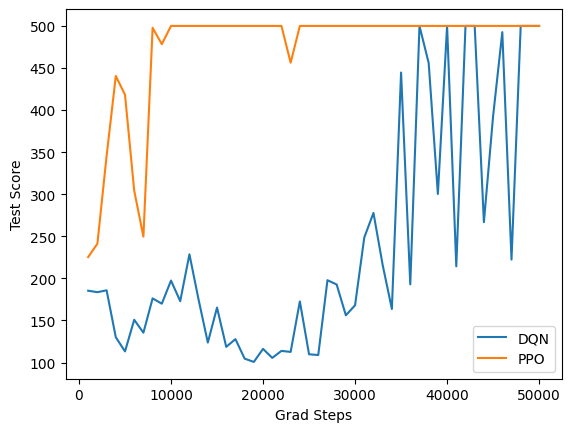

In [56]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in dqn_test_scores], [x[1] for x in dqn_test_scores], label='DQN')
plt.plot([x[0] for x in ppo.test_scores], [x[1] for x in ppo.test_scores], label='PPO')
plt.legend()
plt.ylabel("Test Score")
plt.xlabel("Grad Steps")
plt.show()


We can see that (if you used the same hyperparameters) that PPO performs much better than DQN, achieving a good performance after only 10k gradient steps. Note that really we should train each on several seeds and report the mean performance with some shaded confidence intervals, so if you are interested in this you can do it in your own time to see if the performance gains are the same across a few seeds. **If you managed to implement one of the changes from Rainbow, plot these results and see how it compares to the the vanilla DQN and PPO**. 

--- 